## Fit Machine Learning Models
- Train and Test Models using a Variety of Appropriate [Classification] Algorithms
- Tune (Optimize) Each Model''s Hyperparameters
- Evaluate the Optimally-Fitted Models Against a Hold-Out (Out-of-Sample) Dataset
- Perform K-Fold Cross-Validation Using Each Model
- Determine Each Model''s Accuracy and Identify the Best Model.

### Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import sklearn
print("SciKit-Learn Version:", sklearn.__version__)

if sklearn.__version__ >= '0.18.0':  # Starting with sklearn version 18.0
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
else:
    from sklearn.cross_validation import train_test_split, cross_val_score
    from sklearn.cross_validation import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

SciKit-Learn Version: 0.24.1


### Define Globals

In [2]:
hold_out_percent = 0.2
CLASSIFICATION_TYPE = 'Binary'

###################################################################################################################
# Analyze Input DataTypes and Determine Their Appropriate Conversions for ML
###################################################################################################################
def set_datatypes(dframe):
    for col in dframe.columns:
        if dframe[col].dtypes.str.startswith('int'):
            dframe[col] = pd.to_numeric(dframe[col],
                                        downcast='integer',
                                        errors='coerce')
            
        elif dframe[col].dtypes.str.startswith('float'):
            dframe[col] = pd.to_numeric(dframe[col],
                                        downcast='float',
                                        errors='coerce')
            
        elif dframe[col].dtypes == 'object':
            dframe[col] = dframe[col].astype('category')
        
    return dframe


###################################################################################################################
# Calculate the Null Accuracy Score: Accommodates Binary or Multiple Classification Type
###################################################################################################################
def null_accuracy_score(labels, classification_type):  #NOTE: 'labels' must be a pd.Series
    if classification_type == CLASSIFICATION_TYPE:
        return max(labels[:,].astype(int).mean(), 1 - labels[:,].astype(int).mean())
    
    elif classification_type == CLASSIFICATION_TYPE:
        return labels.value_counts().head(1).item() / len(labels) 
    
    else:
        raise ValueError("Bad input {0}. Must specify either 'Binary' or 'Multiple'.".format(classification_type))
        

##################################################################################################################
# Print Evaluation Metrics: Accuracy and Null Accuracy Scores
###################################################################################################################
def show_accuracy(y_actuals, y_predictions, classification_type):
    accuracy = accuracy_score(y_actuals, y_predictions)
    null_accuracy = null_accuracy_score(y_actuals, classification_type)

    print('----------------------------------------------------------------------------------')
    print('Accuracy (The Percentage of Correct Predictions): %0.3f' % accuracy)
    print('----------------------------------------------------------------------------------')
    print('Null Accuracy (Achieved by Always Predicting the Most Frequent Class): %0.3f' % null_accuracy)
    print('----------------------------------------------------------------------------------')   
    print('True:', list(y_actuals[0:10]))
    print('Pred:', y_predictions[0:10].tolist())
    print('----------------------------------------------------------------------------------\n')
        

##################################################################################################################
# Print Skree Plots: Compare the Explained Variances per Component Between Train/Test and Hold-Out Datasets
###################################################################################################################
def show_skree_plots(components, variances_explained):
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(7, 7))
    
    ax0.set_title("PCA Explained Variances: Train/Test Data")
    ax0.scatter(components, variances_explained[0])
    ax0.set_ylabel('Explained Variance (Eigenvalues)')
    ax0.grid(True)

    ax1.set_title("PCA Explained Variances: Hold-Out Data")
    ax1.scatter(components, variances_explained[1])
    ax1.set_ylabel('Explained Variance (Eigenvalues)')
    ax1.set_xlabel('Number of Components (Eigenvectors)')
    ax1.grid(True)

    plt.tight_layout()
    plt.show()
        

###################################################################################################################
# Print a Confusion Matrix:  Accommodates Binary or Multiple Classification Type
###################################################################################################################
def show_confusion_matrix(y_actuals, y_predictions, y_probabilities, classification_type):
    print('-------------------------------------------------------')
    print('Confusion Matrix')
    print('-------------------------------------------------------')

    cm = pd.crosstab(y_actuals, y_predictions, rownames=['Actuals'], colnames=['Predictions'])
    print(cm)
        
    if classification_type == CLASSIFICATION_TYPE:
        print('-------------------------------------------------------')
        print('Area Under the Curve (AUC): %0.3f' % roc_auc_score(y_actuals, y_probabilities[:, 1]))
        
    print('-------------------------------------------------------\n')
    
    
###################################################################################################################
# Print a Classification Report
###################################################################################################################
def show_classification_report(y_actuals, y_predictions):
    print('-------------------------------------------------------')
    print('Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_actuals, y_predictions))
    print('-------------------------------------------------------\n')
    
    
###################################################################################################################
# Print a Classification Report Resulting from K-Fold Cross-Validation
###################################################################################################################
def show_cv_classification_report(classifier, X, y, K):
    accuracy = cross_val_score(classifier, X, y, scoring='accuracy', cv=K)
    print('--------------------------------------------------------------------------------------------')
    print("Accuracy per Fold: ", accuracy)
    print("Average Accuracy: %0.3f" % accuracy.mean())
    print("Standard Deviation of Accuracy: %0.3f" % accuracy.std())
    print('--------------------------------------------------------------------------------------------')
    
    precision = cross_val_score(classifier, X, y, scoring='precision_weighted', cv=K)
    print("Precision per Fold: ", precision)
    print("Average Precision: %0.3f" % precision.mean())
    print("Standard Deviation of Precision: %0.3f" % precision.std())
    print('--------------------------------------------------------------------------------------------')
    
    recall = cross_val_score(classifier, X, y, scoring='recall_weighted', cv=K)
    print("Recall per Fold: ", recall)
    print("Average Recall: %0.3f" % recall.mean())
    print("Standard Deviation of Recall: %0.3f" % recall.std())
    print('--------------------------------------------------------------------------------------------')
    
    f1 = cross_val_score(classifier, X, y, scoring='f1_weighted', cv=K)
    print("F1 per Fold: ", f1)
    print("Average F1: %0.3f" % f1.mean())
    print("Standard Deviation of F1: %0.3f" % f1.std())
    print('--------------------------------------------------------------------------------------------')
    

###################################################################################################################
# Print a Receiver Operating Characteristic (ROC) Curve Plot (Binary Classification Only).
###################################################################################################################
def show_roc_plot(y_actuals, y_probabilities, classifier_algorithm):
    plt.figure(figsize=(5,5))
    plt.title('ROC Curve (' + classifier_algorithm + ')')

    fpr, tpr, _ = roc_curve(y_actuals, y_probabilities[:, 1])
    auc = roc_auc_score(y_actuals, y_probabilities[:, 1])

    plt.plot(fpr, tpr, color='darkorange', label='ROC Curve (area = %0.2f)' % auc)
    plt.plot([0,1], [0,1], color='steelblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    

###################################################################################################################
# Save a Trained Model to a Pickle File.
###################################################################################################################
def export_model(model, algorithm_name):
    file_name = "Customer_Churn_{0}.pkl".format(algorithm_name)
    file_target = open(os.path.join(os.getcwd(), 'Models', file_name), 'wb')
    pickle.dump(model, file_target, protocol=pickle.HIGHEST_PROTOCOL)
    file_target.close()

### Load Data

In [3]:
# Locate the Data File to be Ingested.
data_dir = os.path.join(os.getcwd(), 'Data')
source_file = os.path.join(data_dir, 'WA-Telco-Customer-Churn-ML.csv')

# Read the Data from the Source File
df = pd.read_csv(source_file, header=0, index_col=0)

# Drop the Unique Identifier
df = df.drop(labels=['Customerid'], axis=1)

# Display the Dimensions of the DataSet Being Used.
print("DataSet Dimensions:", df.shape)

DataSet Dimensions: (7043, 20)


#### Make Appropriate Data Type Assignments.

In [4]:
df = set_datatypes(df)
df.dtypes

Gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
Tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

#### Separate the Independant (Predictor) Variables (X) from the Dependant (Target, Response, or Label) Variable (y)

In [5]:
X = df.drop(labels=['Churn'], axis=1)
y = df.Churn

#### Create a Hold-Out Data Set for Model Evaluation

In [6]:
# Divide into Train/Test and Evaluation (Hold-Out) Sets.
X, X_eval, y, y_eval = train_test_split(X, y, test_size = hold_out_percent,
                                        random_state=42, stratify=y)

# Use 80% of the observations for training and testing...
print('-------------------------------------------------------------------')
print("Train/Test Observations:", X.shape)

# ...And hod out the rest for final evaluation.
print("Evaluation Observations:", X_eval.shape)
print('-------------------------------------------------------------------\n')

# Examine the distribution of Labels for the two datasets.
print("Train/Test Label Distribution:\n", y.value_counts())
print('-------------------------------------------------------------------')
print("Evaluation Label Distribution:\n", y_eval.value_counts())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Train/Test Observations: (5634, 19)
Evaluation Observations: (1409, 19)
-------------------------------------------------------------------

Train/Test Label Distribution:
 0    4139
1    1495
Name: Churn, dtype: int64
-------------------------------------------------------------------
Evaluation Label Distribution:
 0    1035
1     374
Name: Churn, dtype: int64
-------------------------------------------------------------------


#### Create Training and Testing Datasets 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 60% of the observations for training...
print('-------------------------------------------------------------------')
print("Training Observations:", X_train.shape)

# ...And use the rest for testing.
print("Testing Observations:", X_test.shape)
print('-------------------------------------------------------------------\n')

# Examine the distribution of Labels for the two datasets.
print("Training Label Distribution:\n", y_train.value_counts())
print('-------------------------------------------------------------------')
print("Testing Label Distribution:\n", y_test.value_counts())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Training Observations: (4507, 19)
Testing Observations: (1127, 19)
-------------------------------------------------------------------

Training Label Distribution:
 0    3300
1    1207
Name: Churn, dtype: int64
-------------------------------------------------------------------
Testing Label Distribution:
 0    839
1    288
Name: Churn, dtype: int64
-------------------------------------------------------------------


#### Perform Scalar Normalization of Each Dataset.

In [8]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X = sc.fit_transform(X)
X_eval = sc.transform(X_eval)

### Use Principal Component Analysis (PCA) to Reduce Dimensionality

In [9]:
# Define the Number of Components to Target
n_components = 18

# Instantiate a List to Hold Collections of PCA Explained Variances.
variances = []

##### Perform PCA Feature Reduction on the Train/Test Data

In [10]:
%%time

pca = PCA(n_components=n_components)

# Reduce the data, outputting an ndarray
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Get the explained variance associated with each component.
explained_variance = pca.explained_variance_ratio_

# Append the explained variances to the Variances List.
variances.append(explained_variance)

# Print out the explained variance associated with each component.
print(explained_variance)
print('-------------------------------------------------------------------')
print("Total Variance Explained: %0.4f" % sum(explained_variance))
print('-------------------------------------------------------------------')

[0.22299243 0.12198762 0.07830423 0.06384835 0.05773986 0.05299402
 0.0489159  0.04547626 0.04369274 0.0406111  0.03785665 0.03678225
 0.03555508 0.029768   0.0287988  0.02463633 0.01699585 0.01025162]
-------------------------------------------------------------------
Total Variance Explained: 0.9972
-------------------------------------------------------------------
CPU times: user 10.1 ms, sys: 7.28 ms, total: 17.4 ms
Wall time: 11.9 ms


##### Perform PCA Parameter Reduction on the Hold-Out Data

In [11]:
%%time

pca_holdout = PCA(n_components=n_components)

# Reduce the data, outputting an ndarray
X = pca_holdout.fit_transform(X)
X_eval = pca_holdout.transform(X_eval)

# Get the explained variance associated with each component.
explained_variance_holdout = pca_holdout.explained_variance_ratio_

# Append the explained variances to the Variances List.
variances.append(explained_variance_holdout)

# Print out the explained variance associated with each component.
print(explained_variance_holdout)
print('-------------------------------------------------------------------')
print("Total Variance Explained: %0.4f" % sum(explained_variance_holdout))
print('-------------------------------------------------------------------')

[0.22327427 0.12141219 0.07872851 0.0641006  0.05723347 0.05300591
 0.04899128 0.04521393 0.04336747 0.04083954 0.03763136 0.03640652
 0.0357035  0.03014352 0.02936539 0.02480064 0.01685066 0.0101553 ]
-------------------------------------------------------------------
Total Variance Explained: 0.9972
-------------------------------------------------------------------
CPU times: user 33.3 ms, sys: 183 µs, total: 33.5 ms
Wall time: 13.9 ms


##### Use Skree Plots to Illustrate the Explained Variance of Each Component

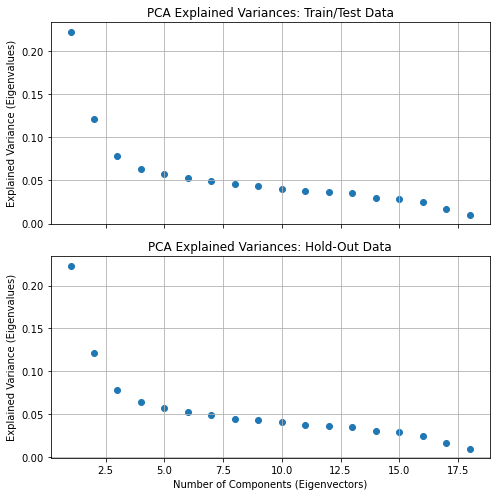

In [12]:
# Get the range of components
components = list(range(1, n_components+1))

# Display the Skree Plots to Compare the two Variance Distributions
show_skree_plots(components, variances)

### Train a Classification Model Using the RandomForestsClassifier 

In [13]:
%%time

# Train using the Training data.
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Make Predictions using the Test data.
y_pred = rfc.predict(X_test)
y_probs = rfc.predict_proba(X_test)

CPU times: user 1.8 s, sys: 12.2 ms, total: 1.81 s
Wall time: 1.81 s


#### Evaluate the Model's Efficacy using Metrics, a Confusion Matrix and Classification Report

----------------------------------------------------------------------------------
Accuracy (The Percentage of Correct Predictions): 0.782
----------------------------------------------------------------------------------
Null Accuracy (Achieved by Always Predicting the Most Frequent Class): 0.744
----------------------------------------------------------------------------------
True: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------

-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------
Predictions    0    1
Actuals              
0            762   77
1            169  119
-------------------------------------------------------
Area Under the Curve (AUC): 0.792
-------------------------------------------------------

-------------------------------------------------------
Classification Report
------------------

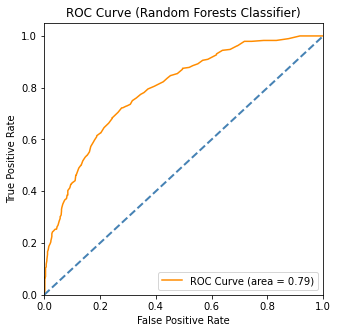

In [14]:
show_accuracy(y_test, y_pred, CLASSIFICATION_TYPE)
show_confusion_matrix(y_test, y_pred, y_probs, CLASSIFICATION_TYPE)
show_classification_report(y_test, y_pred)

if CLASSIFICATION_TYPE == 'Binary':
    show_roc_plot(y_test, y_probs, 'Random Forests Classifier')

#### Perform Hyper-Parameter Tuning for the Random Forests Classifier

In [15]:
%%time

# Define the parameter values to be searched
estimator_range = list(range(2, 21))
criterion_options = ['gini','entropy']
max_features_options = [None, 'auto','sqrt','log2']
max_depth_range = list(range(2, 21))

# Create parameter distributions
param_dist = dict(n_estimators = estimator_range
                  , max_features = max_features_options
                  , criterion = criterion_options
                  , max_depth = max_depth_range
                 )

# Instantiate the grid
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1) 
rand.return_train_score=False

# Finally, fit the grid
rand.fit(X_train, y_train)

CPU times: user 661 ms, sys: 110 ms, total: 771 ms
Wall time: 6.3 s


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20]},
                   random_state=42, scoring='accuracy')

In [16]:
# View the results
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.766355,0.015503,"{'n_estimators': 7, 'max_features': 'auto', 'm..."
1,0.749943,0.013143,"{'n_estimators': 4, 'max_features': None, 'max..."
2,0.774352,0.012298,"{'n_estimators': 11, 'max_features': 'log2', '..."
3,0.775014,0.012327,"{'n_estimators': 14, 'max_features': 'auto', '..."
4,0.780782,0.016402,"{'n_estimators': 6, 'max_features': 'sqrt', 'm..."
5,0.765926,0.024322,"{'n_estimators': 5, 'max_features': 'sqrt', 'm..."
6,0.782336,0.020132,"{'n_estimators': 12, 'max_features': None, 'ma..."
7,0.755264,0.023915,"{'n_estimators': 5, 'max_features': 'auto', 'm..."
8,0.785887,0.012635,"{'n_estimators': 9, 'max_features': 'auto', 'm..."
9,0.732195,0.000745,"{'n_estimators': 2, 'max_features': 'sqrt', 'm..."


In [17]:
dist_mean_scores = rand.cv_results_['mean_test_score']
param_estimators = rand.cv_results_['params']
items = list(range(0, len(param_estimators)))

estimators = []

for i in items:
    estimators.append(param_estimators[i]['n_estimators'])
    estimators.sort()
    
print('-------------------------------------------------------------------')    
print('Mean Test Scores:', dist_mean_scores)
print('-------------------------------------------------------------------')
print('Estimator Values:', estimators)
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Mean Test Scores: [0.76635477 0.74994334 0.77435181 0.77501404 0.78078197 0.7659256
 0.78233555 0.75526435 0.78588667 0.73219512]
-------------------------------------------------------------------
Estimator Values: [2, 4, 5, 5, 6, 7, 9, 11, 12, 14]
-------------------------------------------------------------------


Text(0, 0.5, 'Mean Test Scores')

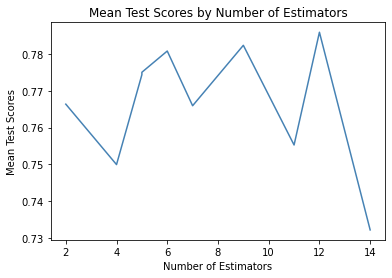

In [18]:
# Plot the scores
plt.title('Mean Test Scores by Number of Estimators')
plt.plot(estimators, dist_mean_scores, color='steelblue')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Scores')

In [19]:
# Examine the best score
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.7858866715939887
{'n_estimators': 9, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'}
RandomForestClassifier(max_depth=6, n_estimators=9, random_state=42)


#### Use the Best Hyper-Parameters to Make Predictions Using the Hold-Out Data

In [20]:
%%time

n_estimators = rand.best_params_['n_estimators']
max_feature = rand.best_params_['max_features']
max_depth = rand.best_params_['max_depth']
criteria = rand.best_params_['criterion']

rfc = RandomForestClassifier(n_estimators = n_estimators
                             , max_features = max_feature
                             , criterion = criteria
                             , max_depth = max_depth
                             , random_state = 42
                            )
rfc.fit(X, y)

y_pred = rand.predict(X_eval)
y_probs = rand.predict_proba(X_eval)

CPU times: user 140 ms, sys: 4.25 ms, total: 144 ms
Wall time: 142 ms


#### Evaluate the Model's Efficacy using Metrics, a Confusion Matrix and Classification Report

----------------------------------------------------------------------------------
Accuracy (The Percentage of Correct Predictions): 0.784
----------------------------------------------------------------------------------
Null Accuracy (Achieved by Always Predicting the Most Frequent Class): 0.735
----------------------------------------------------------------------------------
True: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Pred: [0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
----------------------------------------------------------------------------------

-------------------------------------------------------
Confusion Matrix
-------------------------------------------------------
Predictions    0    1
Actuals              
0            956   79
1            225  149
-------------------------------------------------------
Area Under the Curve (AUC): 0.818
-------------------------------------------------------

-------------------------------------------------------
Classification Report
------------------

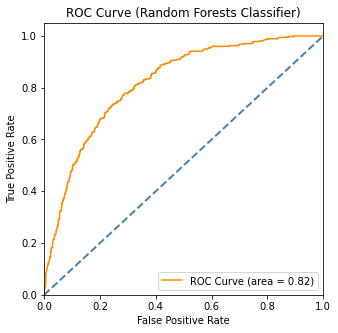

In [21]:
show_accuracy(y_eval, y_pred, CLASSIFICATION_TYPE)
show_confusion_matrix(y_eval, y_pred, y_probs, CLASSIFICATION_TYPE)
show_classification_report(y_eval, y_pred)

if CLASSIFICATION_TYPE == 'Binary':
    show_roc_plot(y_eval, y_probs, 'Random Forests Classifier')

#### Use K-Fold Cross-Validation to Detect Overfitting

In [22]:
%%time

show_cv_classification_report(rfc, X, y, 10)

--------------------------------------------------------------------------------------------
Accuracy per Fold:  [0.80851064 0.80851064 0.79432624 0.78546099 0.77975133 0.77975133
 0.77619893 0.79218472 0.78152753 0.77442274]
Average Accuracy: 0.788
Standard Deviation of Accuracy: 0.012
--------------------------------------------------------------------------------------------
Precision per Fold:  [0.79815364 0.7983703  0.78430719 0.76987283 0.76225442 0.76291434
 0.75727279 0.77862212 0.76434476 0.75573547]
Average Precision: 0.773
Standard Deviation of Precision: 0.015
--------------------------------------------------------------------------------------------
Recall per Fold:  [0.80851064 0.80851064 0.79432624 0.78546099 0.77975133 0.77975133
 0.77619893 0.79218472 0.78152753 0.77442274]
Average Recall: 0.788
Standard Deviation of Recall: 0.012
--------------------------------------------------------------------------------------------
F1 per Fold:  [0.79335543 0.79260172 0.7680807

#### Export the Best Fit Model to a Pickle file.

In [23]:
export_model(rfc, "RandomForestsClassifier")